# BentoML Example: PyTorch Image Classifier

[BentoML](http://bentoml.ai) is an open source platform for machine learning model serving and deployment. In this project we will use BentoML to package the image classifier model, and build a containerized REST API model server.

This notebook was built based on the official pytorch tutorial https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=pytorch&ea=pytorch-cifar10-image-classification&dt=pytorch-cifar10-image-classification)

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install bentoml
!pip install torch torchvision pillow

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Training an image classifier

We will do the following steps in order:

* Load and normalizing the CIFAR10 training and test datasets using torchvision
* Define a Convolutional Neural Network
* Define a loss function
* Train the network on the training data
* Test the network on the test data
* Model Serving with BentoML


## 1 Loading and Normalizing CIFAR10

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


Let us show some of the training images, for fun.

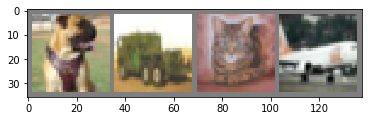

  dog truck   cat plane


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2 Define a Convolutional Neural Network

Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined).

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

## 3 Define a Loss function and optimize

Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4 Train the network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [6]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.145
[1,  4000] loss: 1.810
[1,  6000] loss: 1.657
[1,  8000] loss: 1.583
[1, 10000] loss: 1.525
[1, 12000] loss: 1.506
Finished Training


## 5 Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

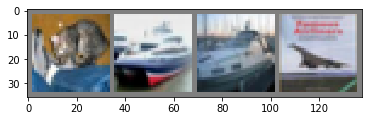

GroundTruth:    cat  ship  ship plane


In [7]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Let us look at how the network performs on the whole dataset.

In [8]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 47 %


# 6 Model Serving with BentoML


First, define ML service with BentoML

In [9]:
%%writefile pytorch_image_classifier.py

from PIL import Image

import torch
from torch.autograd import Variable
from torchvision import transforms

import bentoml
from bentoml.artifact import PytorchModelArtifact
from bentoml.adapters import FileInput


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

@bentoml.env(pip_dependencies=['torch', 'numpy', 'torchvision', 'scikit-learn'])
@bentoml.artifacts([PytorchModelArtifact('net')])
class PytorchImageClassifier(bentoml.BentoService):
    
    @bentoml.utils.cached_property
    def transform(self):
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    
    @bentoml.api(input=FileInput())
    def predict(self, file_streams):
        input_datas = []
        for fs in file_streams:
            img = Image.open(fs).resize((32, 32))
            input_datas.append(self.transform(img))

        outputs = self.artifacts.net(Variable(torch.stack(input_datas)))
        _, output_classes = outputs.max(dim=1)

        return [classes[output_class] for output_class in output_classes]

Overwriting pytorch_image_classifier.py


Now you can instantiate a BentoService defined above with the trained model, and save the entire BentoService to a file archive:

In [10]:
# 1) import the custom BentoService defined above
from pytorch_image_classifier import PytorchImageClassifier

# 2) `pack` it with required artifacts
bento_svc = PytorchImageClassifier()
bento_svc.pack('net', net)

# 3) save your BentoSerivce to file archive
saved_path = bento_svc.save()
print(saved_path)

[2020-08-03 17:55:33,425] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-08-03 17:55:33,573] WARNING - BentoML by default does not include spacy and torchvision package when using PytorchModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_dependencies=['torchvision'])` when defining a BentoService
[2020-08-03 17:55:44,087] INFO - Detect BentoML installed in development model, copying local BentoML module file to target saved bundle path
running sdist
running egg_info
writing BentoML.egg-info/PKG-INFO
writing dependency_links to BentoML.egg-info/dependency_links.txt
writing entry points to BentoML.egg-info/entry_points.txt
writing requirements to BentoML.egg-in

no previously-included directories found matching 'e2e_tests'
no previously-included directories found matching 'tests'
no previously-included directories found matching 'benchmark'


writing manifest file 'BentoML.egg-info/SOURCES.txt'
running check
creating BentoML-0.8.3+47.g5daa71b
creating BentoML-0.8.3+47.g5daa71b/BentoML.egg-info
creating BentoML-0.8.3+47.g5daa71b/bentoml
creating BentoML-0.8.3+47.g5daa71b/bentoml/adapters
creating BentoML-0.8.3+47.g5daa71b/bentoml/artifact
creating BentoML-0.8.3+47.g5daa71b/bentoml/cli
creating BentoML-0.8.3+47.g5daa71b/bentoml/clipper
creating BentoML-0.8.3+47.g5daa71b/bentoml/configuration
creating BentoML-0.8.3+47.g5daa71b/bentoml/configuration/__pycache__
creating BentoML-0.8.3+47.g5daa71b/bentoml/handlers
creating BentoML-0.8.3+47.g5daa71b/bentoml/marshal
creating BentoML-0.8.3+47.g5daa71b/bentoml/saved_bundle
creating BentoML-0.8.3+47.g5daa71b/bentoml/server
creating BentoML-0.8.3+47.g5daa71b/bentoml/utils
creating BentoML-0.8.3+47.g5daa71b/bentoml/yatai
creating BentoML-0.8.3+47.g5daa71b/bentoml/yatai/client
creating BentoML-0.8.3+47.g5daa71b/bentoml/yatai/deployment
creating BentoML-0.8.3+47.g5daa71b/bentoml/yatai/dep

## BentoService with BentoML CLI

In [12]:
!bentoml get PytorchImageClassifier

BENTO_SERVICE                                 CREATED_AT        APIS                   ARTIFACTS
PytorchImageClassifier:20200127115720_71B982  2020-01-27 19:57  predict::ImageHandler  net::PytorchModelArtifact
PytorchImageClassifier:20200127114517_C3118B  2020-01-27 19:45  predict::ImageHandler  net::PytorchModelArtifact


In [11]:
!bentoml get PytorchImageClassifier:latest

[2020-08-03 17:55:51,187] INFO - Getting latest version PytorchImageClassifier:20200803175534_4C7106
{
  "name": "PytorchImageClassifier",
  "version": "20200803175534_4C7106",
  "uri": {
    "type": "LOCAL",
    "uri": "/home/bentoml/bentoml/repository/PytorchImageClassifier/20200803175534_4C7106"
  },
  "bentoServiceMetadata": {
    "name": "PytorchImageClassifier",
    "version": "20200803175534_4C7106",
    "createdAt": "2020-08-03T09:55:45.058786Z",
    "env": {
      "condaEnv": "name: bentoml-PytorchImageClassifier\nchannels:\n- defaults\ndependencies:\n- python=3.6.10\n- pip\n",
      "pipDependencies": "torch\nbentoml==0.8.3\nnumpy\ntorchvision\nscikit-learn",
      "pythonVersion": "3.6.10",
      "dockerBaseImage": "bentoml/model-server:0.8.3"
    },
    "artifacts": [
      {
        "name": "net",
        "artifactType": "PytorchModelArtifact"
      }
    ],
    "apis": [
      {
        "name": "predict",
        "inputType": "FileInput",
        "docs": "BentoService inf

In [12]:
!bentoml info PytorchImageClassifier:latest

[2020-08-03 17:56:08,207] INFO - Getting latest version PytorchImageClassifier:20200803175534_4C7106
[2020-08-03 17:56:08,227] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-08-03 17:56:08,242] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.8.3, but loading from BentoML version 0.8.3+47.g5daa71b
{
  "name": "PytorchImageClassifier",
  "version": "20200803175534_4C7106",
  "created_at": "2020-08-03T09:55:44.025755Z",
  "env": {
    "conda_env": "name: bentoml-PytorchImageClassifier\nchannels:\n- defaults\ndependencies:\n- python=3.6.10\n- pip\n",
    "pip_dependencies": "torch\nbentoml==0.8.3\nnumpy\ntorchvision\nscikit-learn",
    "python_version": "3.6.10",
    "docker_base_image": "bentoml/model-server:0.8.3"
  },
  "artifacts": [

In [13]:
!bentoml run PytorchImageClassifier:latest predict  --input=bird.jpg

[2020-08-03 17:56:18,947] INFO - Getting latest version PytorchImageClassifier:20200803175534_4C7106
[2020-08-03 17:56:20,021] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-08-03 17:56:20,038] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.8.3, but loading from BentoML version 0.8.3+47.g5daa71b
[2020-08-03 17:56:20,832] WARNING - BentoML by default does not include spacy and torchvision package when using PytorchModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_dependencies=['torchvision'])` when defining a BentoService
deer


## Model Serving via REST API

In your termnial, run the following command to start the REST API server:

In [14]:
!bentoml serve PytorchImageClassifier:latest --enable-microbatch

[2020-08-03 17:56:58,854] INFO - Getting latest version PytorchImageClassifier:20200803175534_4C7106
[2020-08-03 17:56:58,855] INFO - Starting BentoML API server in development mode..
[2020-08-03 17:56:59,917] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-08-03 17:56:59,940] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.8.3, but loading from BentoML version 0.8.3+47.g5daa71b
[2020-08-03 17:57:00,626] WARNING - BentoML by default does not include spacy and torchvision package when using PytorchModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_dependencies=['torchvision'])` when defining a Bent

Open a terminal and go to the directory of the current notebook, then run the following command to evaluate.

```bash
curl -X POST "http://127.0.0.1:5000/predict" -H "Content-Type: image/*" --data-binary "@bird.jpg"
```

alternatively:
```bash
curl -X POST "http://127.0.0.1:5000/predict" -F image=@bird.png
```


Go visit http://127.0.0.1:5000/ from your browser, click `/predict` -> `Try it out` -> `Choose File` -> `Execute` to sumbit an image from your computer

# Use BentoService as PyPI package

In [15]:
!pip install --quiet {saved_path}

In [16]:
!PytorchImageClassifier run predict --input=bird.jpg

deer


# Deploy BentoService as REST API server to the cloud


BentoML support deployment to multiply cloud provider services, such as AWS Lambda, AWS Sagemaker, Google Cloudrun and etc. You can find the full list and guide on the documentation site at https://docs.bentoml.org/en/latest/deployment/index.html

For fastai pet classification, we are going to deploy to AWS Sagemaker

**Deploying to Sagemaker with `bentoml sagemaker deploy`**

In [22]:
!bentoml sagemaker deploy first-pytorch -b PytorchImageClassifier:latest --api-name predict

Deploying Sagemaker deployment \[2020-01-27 12:05:30,122] INFO - Step 1/11 : FROM continuumio/miniconda3:4.7.12
[2020-01-27 12:05:30,124] INFO - 

[2020-01-27 12:05:30,125] INFO -  ---> 406f2b43ea59

[2020-01-27 12:05:30,125] INFO - Step 2/11 : EXPOSE 8080
[2020-01-27 12:05:30,125] INFO - 

[2020-01-27 12:05:30,125] INFO -  ---> Using cache

[2020-01-27 12:05:30,125] INFO -  ---> 7c8096d6922f

[2020-01-27 12:05:30,125] INFO - Step 3/11 : RUN set -x      && apt-get update      && apt-get install --no-install-recommends --no-install-suggests -y libpq-dev build-essential     && apt-get install -y nginx      && rm -rf /var/lib/apt/lists/*
[2020-01-27 12:05:30,125] INFO - 

[2020-01-27 12:05:30,126] INFO -  ---> Using cache

[2020-01-27 12:05:30,126] INFO -  ---> 5b00a58f3bce

[2020-01-27 12:05:30,126] INFO - Step 4/11 : RUN conda install pip numpy scipy       && pip install gunicorn gevent
[2020-01-27 12:05:30,126] INFO - 

[2020-01-27 12:05:30,126] INFO -  ---> Using cache

[2020-01-27 12

**We can use `bentoml sagemaker get <deployment name>` to get the latest information**

In [23]:
!bentoml sagemaker get first-pytorch

{
  "namespace": "dev",
  "name": "first-pytorch",
  "spec": {
    "bentoName": "PytorchImageClassifier",
    "bentoVersion": "20200127115720_71B982",
    "operator": "AWS_SAGEMAKER",
    "sagemakerOperatorConfig": {
      "region": "us-west-2",
      "instanceType": "ml.m4.xlarge",
      "instanceCount": 1,
      "apiName": "predict"
    }
  },
  "state": {
    "state": "RUNNING",
    "infoJson": {
      "EndpointName": "dev-first-pytorch",
      "EndpointArn": "arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-first-pytorch",
      "EndpointConfigName": "dev-first-pytorch-PytorchImageClassifier-20200127115720-71B982",
      "ProductionVariants": [
        {
          "VariantName": "dev-first-pytorch-PytorchImageClassifier-20200127115720-71B982",
          "DeployedImages": [
            {
              "SpecifiedImage": "192023623294.dkr.ecr.us-west-2.amazonaws.com/pytorchimageclassifier-sagemaker:20200127115720_71B982",
              "ResolvedImage": "192023623294.dkr.ecr.us-we

**Quick test with sample data to validate prediction result from the deployment**

In [4]:
!aws sagemaker-runtime invoke-endpoint --endpoint-name dev-first-pytorch \
--body fileb:///Users/bozhaoyu/src/bento_gallery/pytorch/cifar10-image-classification/bird.jpg \
--content-type image/jpg output.json && cat output.json

{
    "ContentType": "application/json",
    "InvokedProductionVariant": "dev-first-pytorch-PytorchImageClassifier-20200127115720-71B982"
}
"bird"

**`bentoml sagemaker list` is great tool to list all of the sagemaker dpeloyments**

In [5]:
!bentoml sagemaker list

NAME           NAMESPACE    LABELS    PLATFORM       STATUS    AGE
first-pytorch  dev                    aws-sagemaker  running   38 minutes and 11.5 seconds


**`bentoml sagemaker delete` delete Sagemaker deployment and its related resources**

In [6]:
!bentoml sagemaker delete first-pytorch

Successfully deleted AWS Sagemaker deployment "first-pytorch"
